In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
from tqdm import trange
sys.path.insert(0, './Persistent_Homology')
sys.path.insert(0, './model')
sys.path.insert(0, './numerical')

from gratings import grating_model, GRATING_PARS, get_locations
import gratings
from plotting import plot_data, plot_mean_against_index, show_feature
from persistence import persistence
from decoding import cohomological_parameterization, remove_feature
from noisereduction import PCA_reduction, z_cutoff
from load import pkl_load, pkl_save
import ipywidgets as widgets
import sympy as sp

# matplotlib.use("nbagg")

In [3]:
@widgets.interact(
 stim_theta = widgets.FloatSlider(0, min=0, max=180, step=5),
 stim_phi = widgets.FloatSlider(90, min=0, max=360, step=10),
 stim_freq = widgets.FloatSlider(1.5, min=0, max=10, step=0.5),
 RF_theta = widgets.FloatSlider(0, min=0, max=180, step=5),
 RF_phi = widgets.FloatSlider(90, min=0, max=360, step=10),
 RF_freq = widgets.FloatSlider(1.5, min=0, max=10, step=0.5),
 RF_radius = widgets.FloatSlider(0.5, min=0, max=1, step=0.1), 
 RF_x = widgets.FloatSlider(0.5, min=-1, max=1, step=0.1),
 RF_y = widgets.FloatSlider(-0.5, min=-1, max=1, step=0.1)
 )

def plot_grating(stim_theta, stim_phi, stim_freq, RF_theta, RF_phi, RF_freq, RF_radius, RF_x, RF_y):
    stim_grating = (stim_theta/180*np.pi, stim_freq, stim_phi/180*np.pi, 1)
    RF_grating = (RF_theta/180*np.pi, RF_freq, RF_phi/180*np.pi, 1)
    stim_grat_image = gratings.grating_image(grating=stim_grating, plot=False)
    RF_grat_image = gratings.grating_image(grating=RF_grating, gabor=True, rf_sigma=RF_radius, center=(RF_y, RF_x), plot=False)
    
    fig, ax = plt.subplots(1,5, figsize=(25,6))

    ax[0].imshow(stim_grat_image,"gray", vmin = -1, vmax = 1, extent=[-1,1,1,-1]) 
    receptive_field = plt.Circle((RF_x, RF_y), RF_radius, color='b', fill=False)
    ax[0].add_patch(receptive_field)
    ax[0].legend([receptive_field], ['receptive field'])
    ax[0].invert_yaxis()

    ax[1].imshow(RF_grat_image,"gray", vmin = -1, vmax = 1, extent=[-1,1,1,-1]) 
    receptive_field = plt.Circle((RF_x, RF_y), RF_radius, color='b', fill=False)
    ax[1].add_patch(receptive_field)
    ax[1].legend([receptive_field], ['receptive field'])    
    ax[1].invert_yaxis()

    response = gratings.response(RF_grating, stim_grating, rf_sigma=RF_radius, center=(RF_y, RF_x))
    ax[2].axhline(response)
    ax[2].set(ylim=[0,1])

    # Nstim = (20, 1, 20, 1)
    # stim_list = gratings.get_locations(Nstim)
    # rates = np.zeros([len(stim_list)])
    # iterator = trange(0, len(stim_list), position=0, leave=True)
    # iterator.set_description("Simulating data stim_list")
    # for i in iterator:
    #     rates[i] = response(stim_list[i], RF_grating, rf_sigma=RF_radius, center=(RF_y, RF_x))

    fig.show()
#     return fig

interactive(children=(FloatSlider(value=0.0, description='stim_theta', max=180.0, step=5.0), FloatSlider(value…

In [9]:
class simple_cell_model:
    def __init__(self, Nn, Np, deltaT=None, random_focal_points=False):
        self.GRATING_PARS = GRATING_PARS
        self.Nn = Nn
        self.num_units = self.Nn ** 2
        self.Np = Np
        self.deltaT =  deltaT
        self.random_focal_points = random_focal_points
        self.Np_dict = {g:self.Np[i] for i, g in enumerate(self.GRATING_PARS)}

        self.joint_tuning = np.zeros((self.num_units, self.Np_dict['orientation'], self.Np_dict['phase']))
        self.var_list = ['orientation', 'phase']
        self.axis_dict = {'orientation': 1, 'phase': 2}
        self.marginal_tuning = {var:np.zeros((self.num_units, self.Np_dict[var])) for var in self.Np_dict}
        self.simulate()

        stim_vals = np.array(get_locations(Np))
        self.stim_val =  {var: np.unique(stim_vals[:, GRATING_PARS.index(var)]) for var in self.var_list}

    def save(self, filename):
        pkl_save(filename, self)

    def simulate(self):
        x, _ = grating_model(Nn=self.Nn, Np=self.Np, deltaT=self.deltaT, random_focal_points=self.random_focal_points)
        self.joint_tuning = np.array(x).reshape(self.Np_dict['orientation'], self.Np_dict['phase'], self.num_units).transpose((2,0,1))
        for var1, var2 in zip(self.var_list, self.var_list[::-1]):
            self.marginal_tuning[var1] = np.mean(self.joint_tuning, axis=self.axis_dict[var2])

    # def marginal_tuning(self, var='orientation'): # add integration range
    #     """
    #     :type label: {'orientation', 'phase'}
    #     """

    def plot_joint_tuning(self):
        fig, ax = plt.subplots(self.Nn, self.Nn, figsize=(self.Nn*4, self.Nn*4))
        for unit_id in range(self.num_units):
            r, c = unit_id//self.Nn, unit_id%self.Nn
            ax0 = ax[r, c]
            ax0.imshow(self.joint_tuning[unit_id], extent=[0, 360, 180, 0], aspect='auto')
            ax0.set(xlabel='phase', ylabel='orientation')

        fig.suptitle('joint tuning', weight='bold', y=1.01)
        plt.tight_layout()
        plt.show()

    def plot_marginal_tuning(self, var):
        fig, ax = plt.subplots(self.Nn, self.Nn, figsize=(self.Nn*4, self.Nn*4))
        for unit_id in range(self.num_units):
            r, c = unit_id//self.Nn, unit_id%self.Nn
            ax0 = ax[r, c]
            ax0.plot(self.stim_val[var], self.marginal_tuning[var][unit_id])
            ax0.set(xlabel=var)

        fig.suptitle(var + ' selectivity', weight='bold', y=1.01)
        plt.tight_layout()
        plt.show()
    
    def plot_all(self):
        self.plot_joint_tuning()
        for var in self.var_list:
            self.plot_marginal_tuning(var=var)

In [ ]:
# create and save model of simple cell population response to grating stimuli
Np = (20, 1, 20, 1)
# Np = (5, 1, 5, 1)
Nn = 5
model_center_fp = simple_cell_model(Nn=Nn, Np=Np, deltaT=None, random_focal_points=False)
model_random_fp = simple_cell_model(Nn=Nn, Np=Np, deltaT=None, random_focal_points=True)

model_center_fp.save('simple_cell_center_fp')
model_random_fp.save('simple_cell_random_fp')

Simulating data points:  76%|███████▌  | 303/400 [01:44<00:40,  2.42it/s]

In [10]:
# load model of simple cell population response to grating stimuli
model_center_fp = pkl_load('simple_cell_center_fp')
model_random_fp = pkl_load('simple_cell_random_fp')

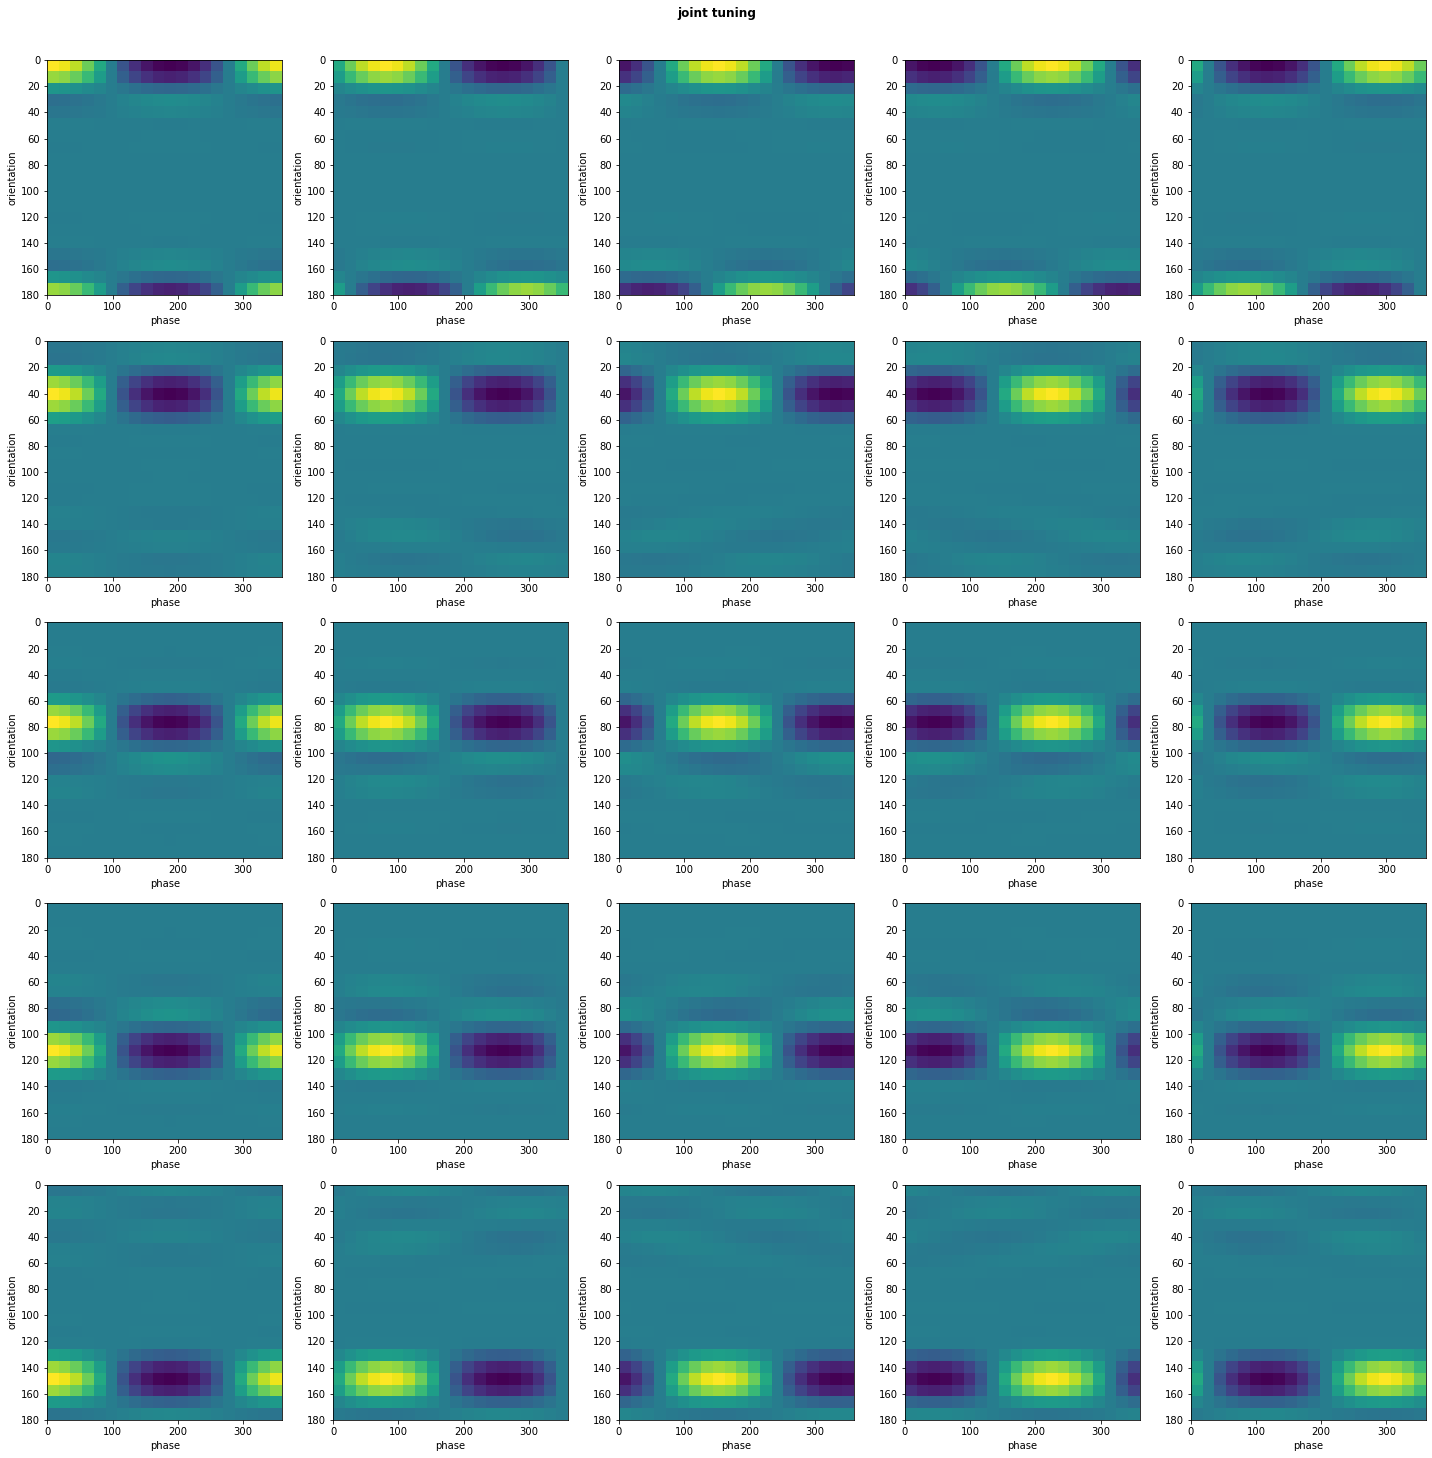

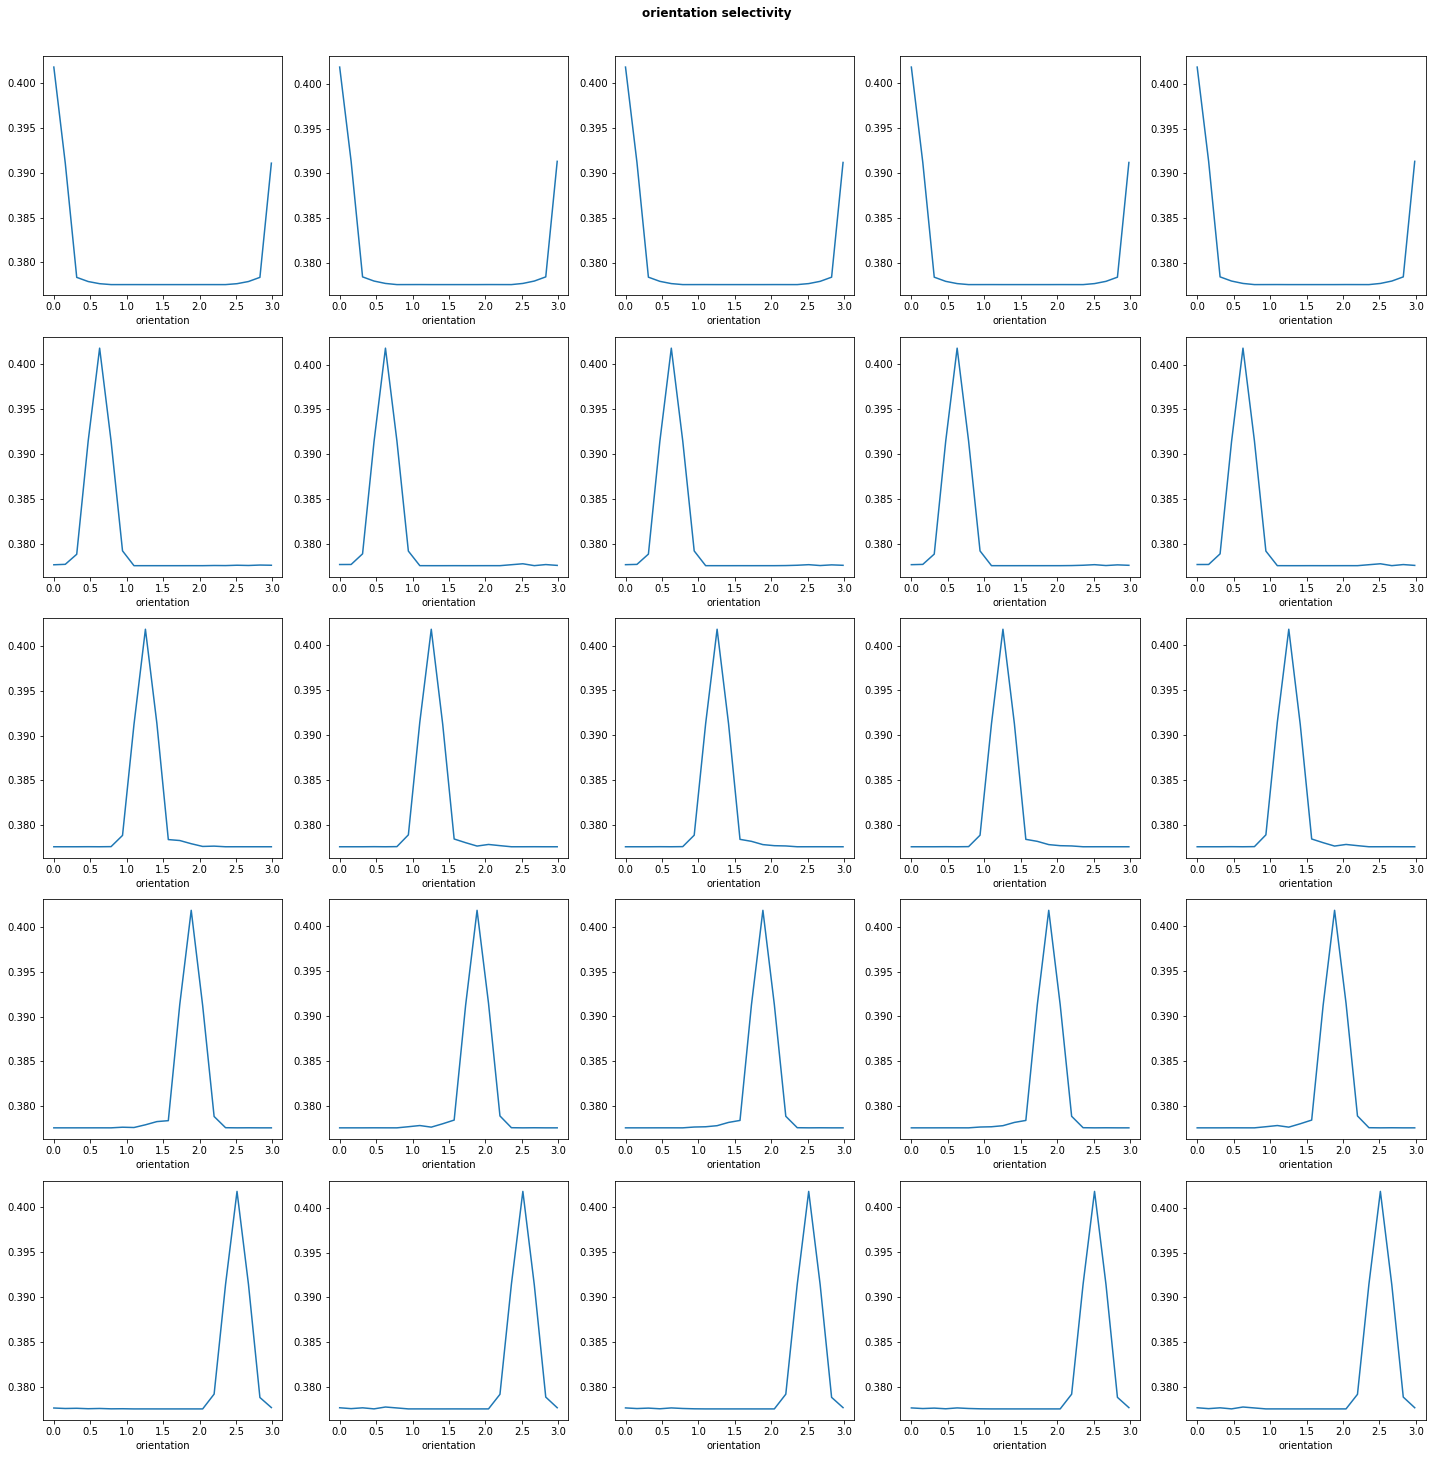

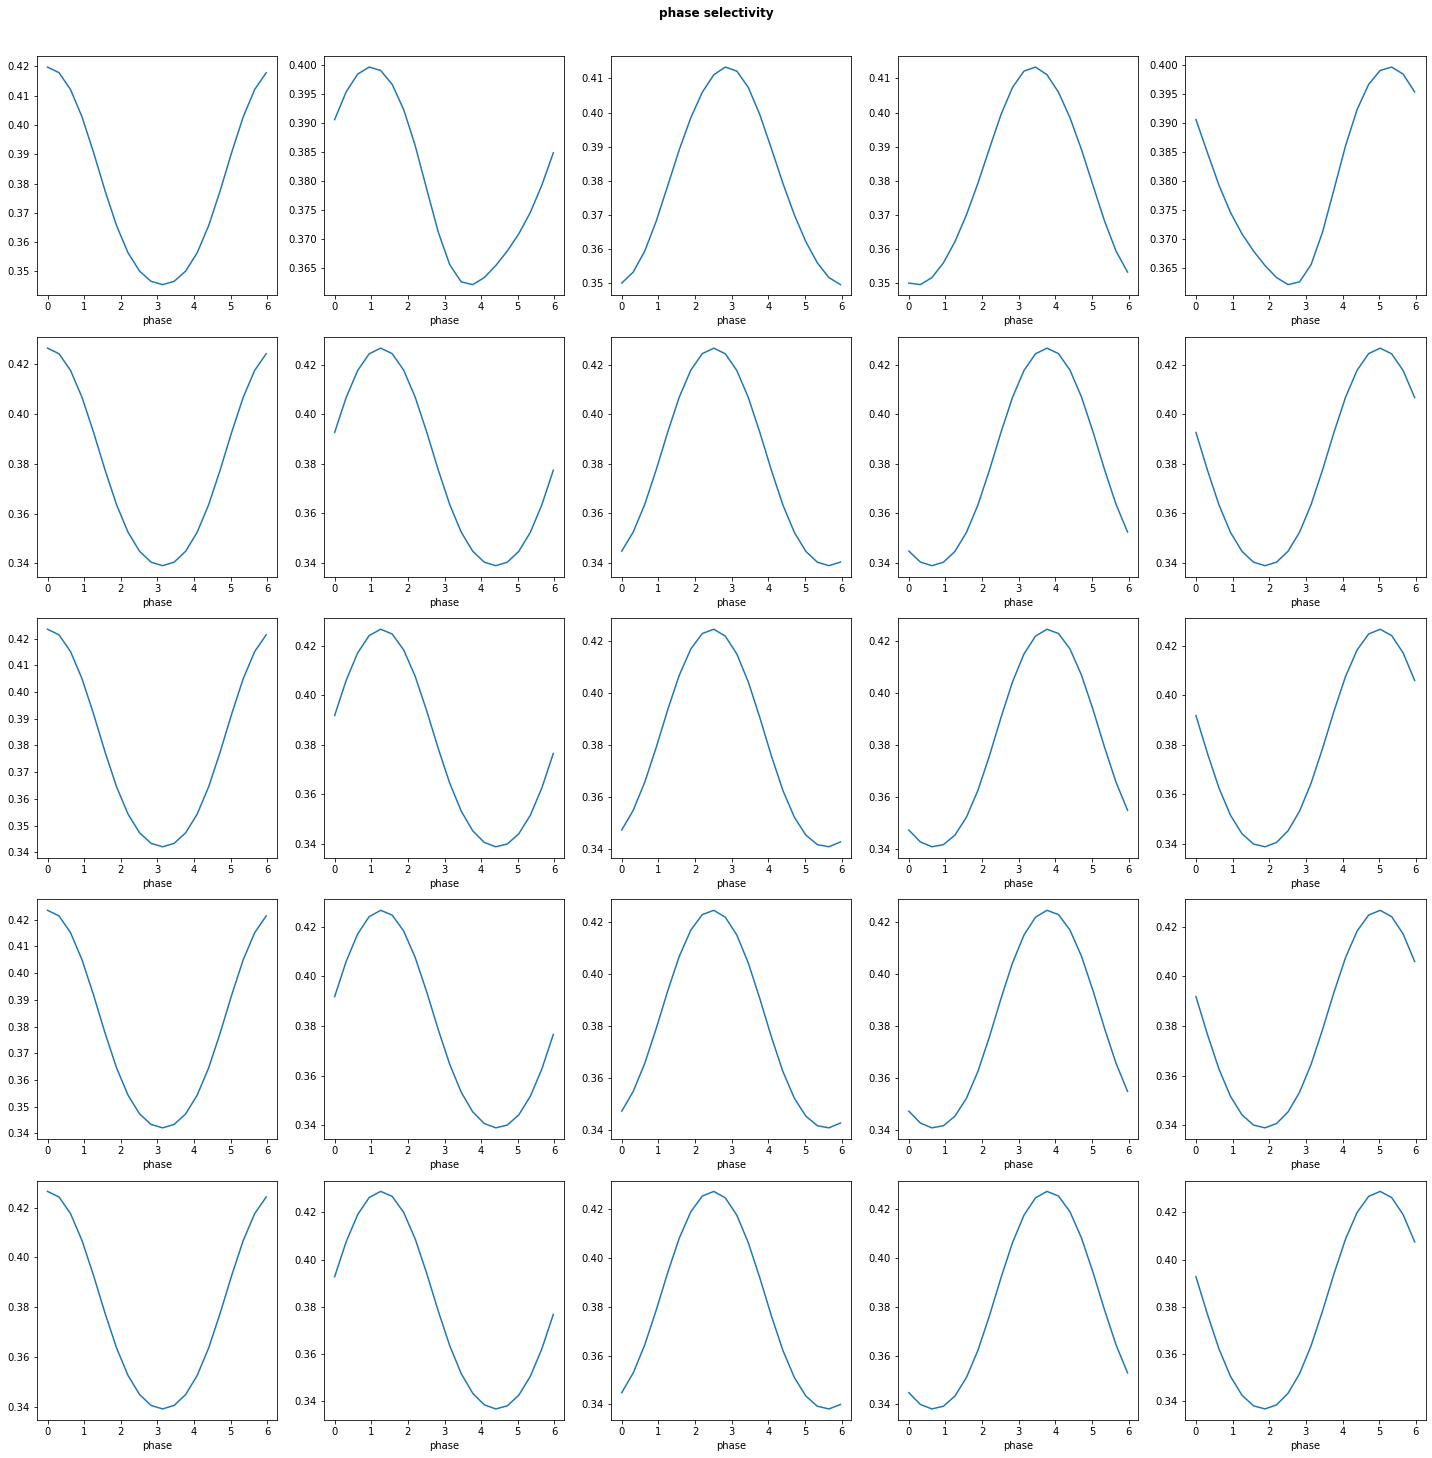

In [11]:
model_center_fp.plot_all()

In [6]:
plt.plot(np.mean(model_center_fp.joint_tuning[0], axis=1))

<IPython.core.display.Javascript object>

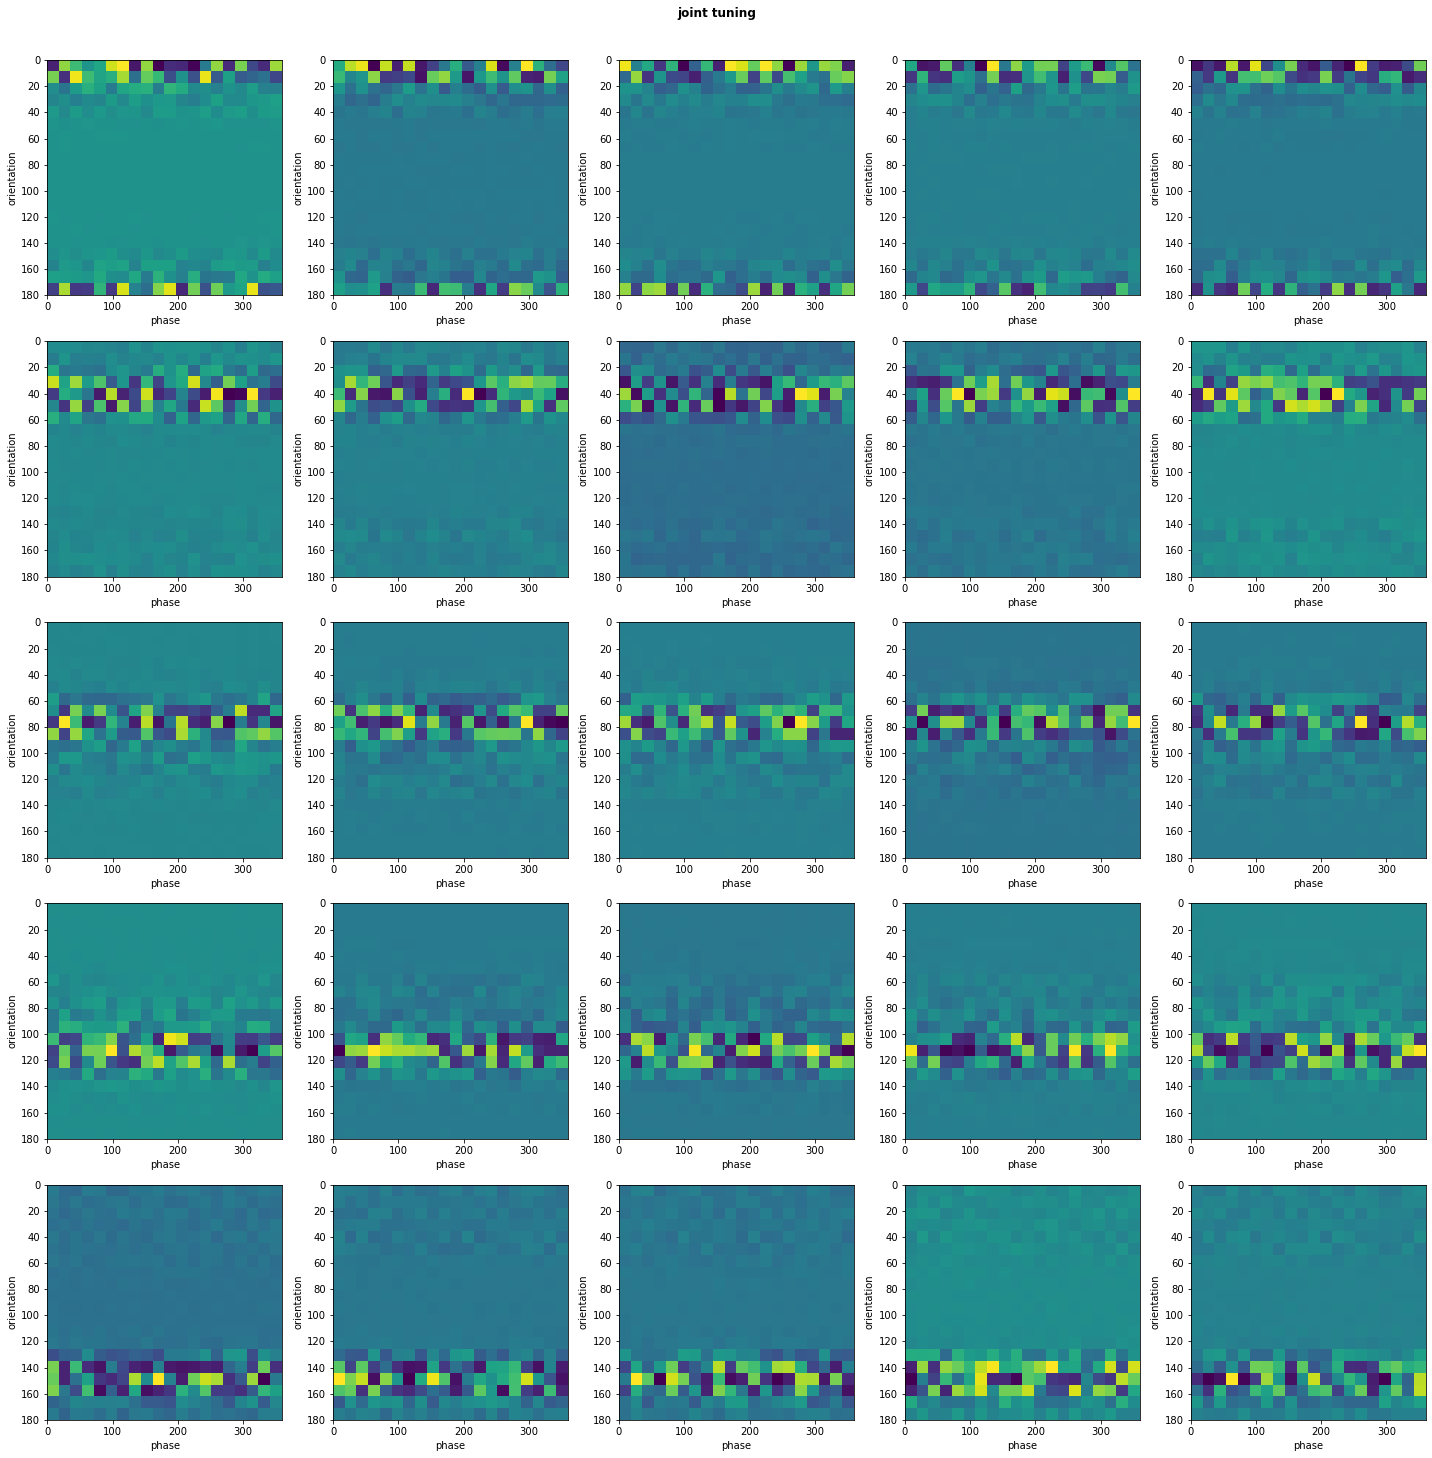

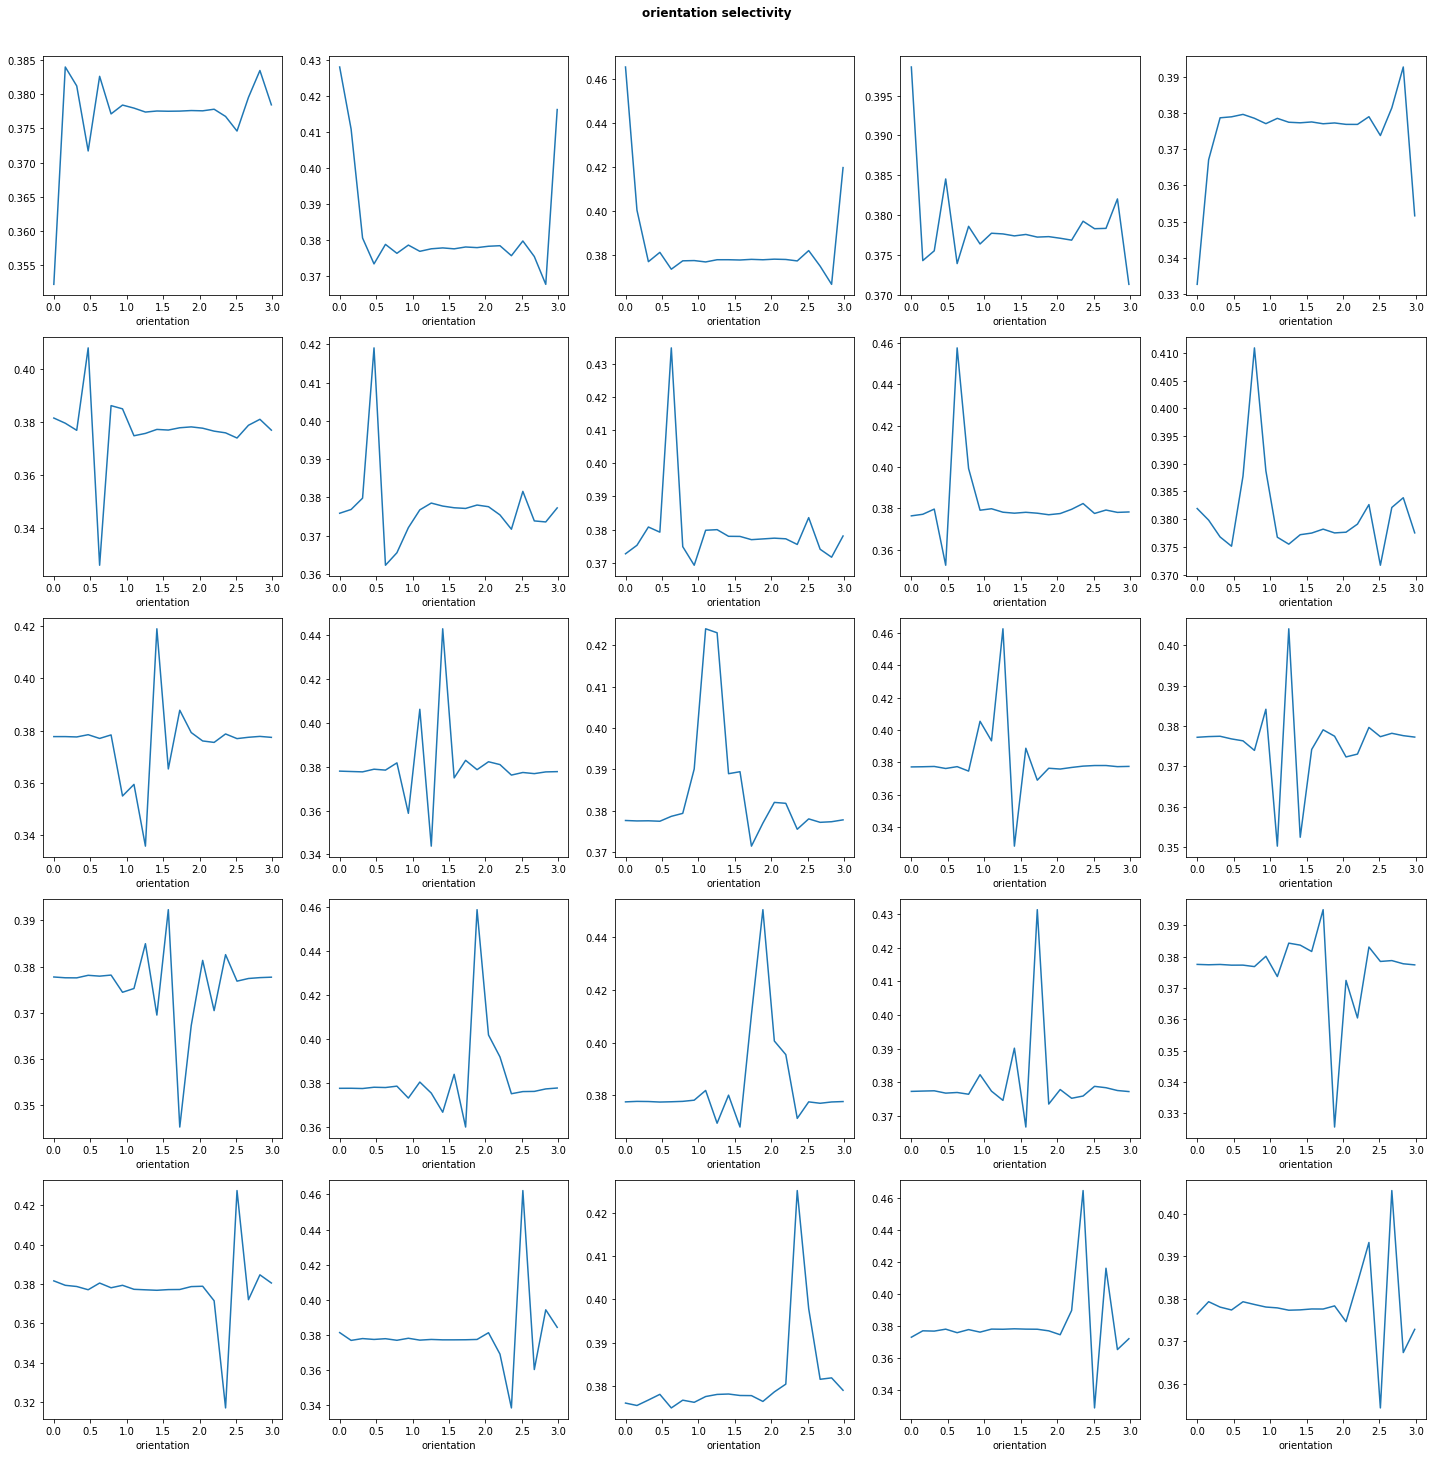

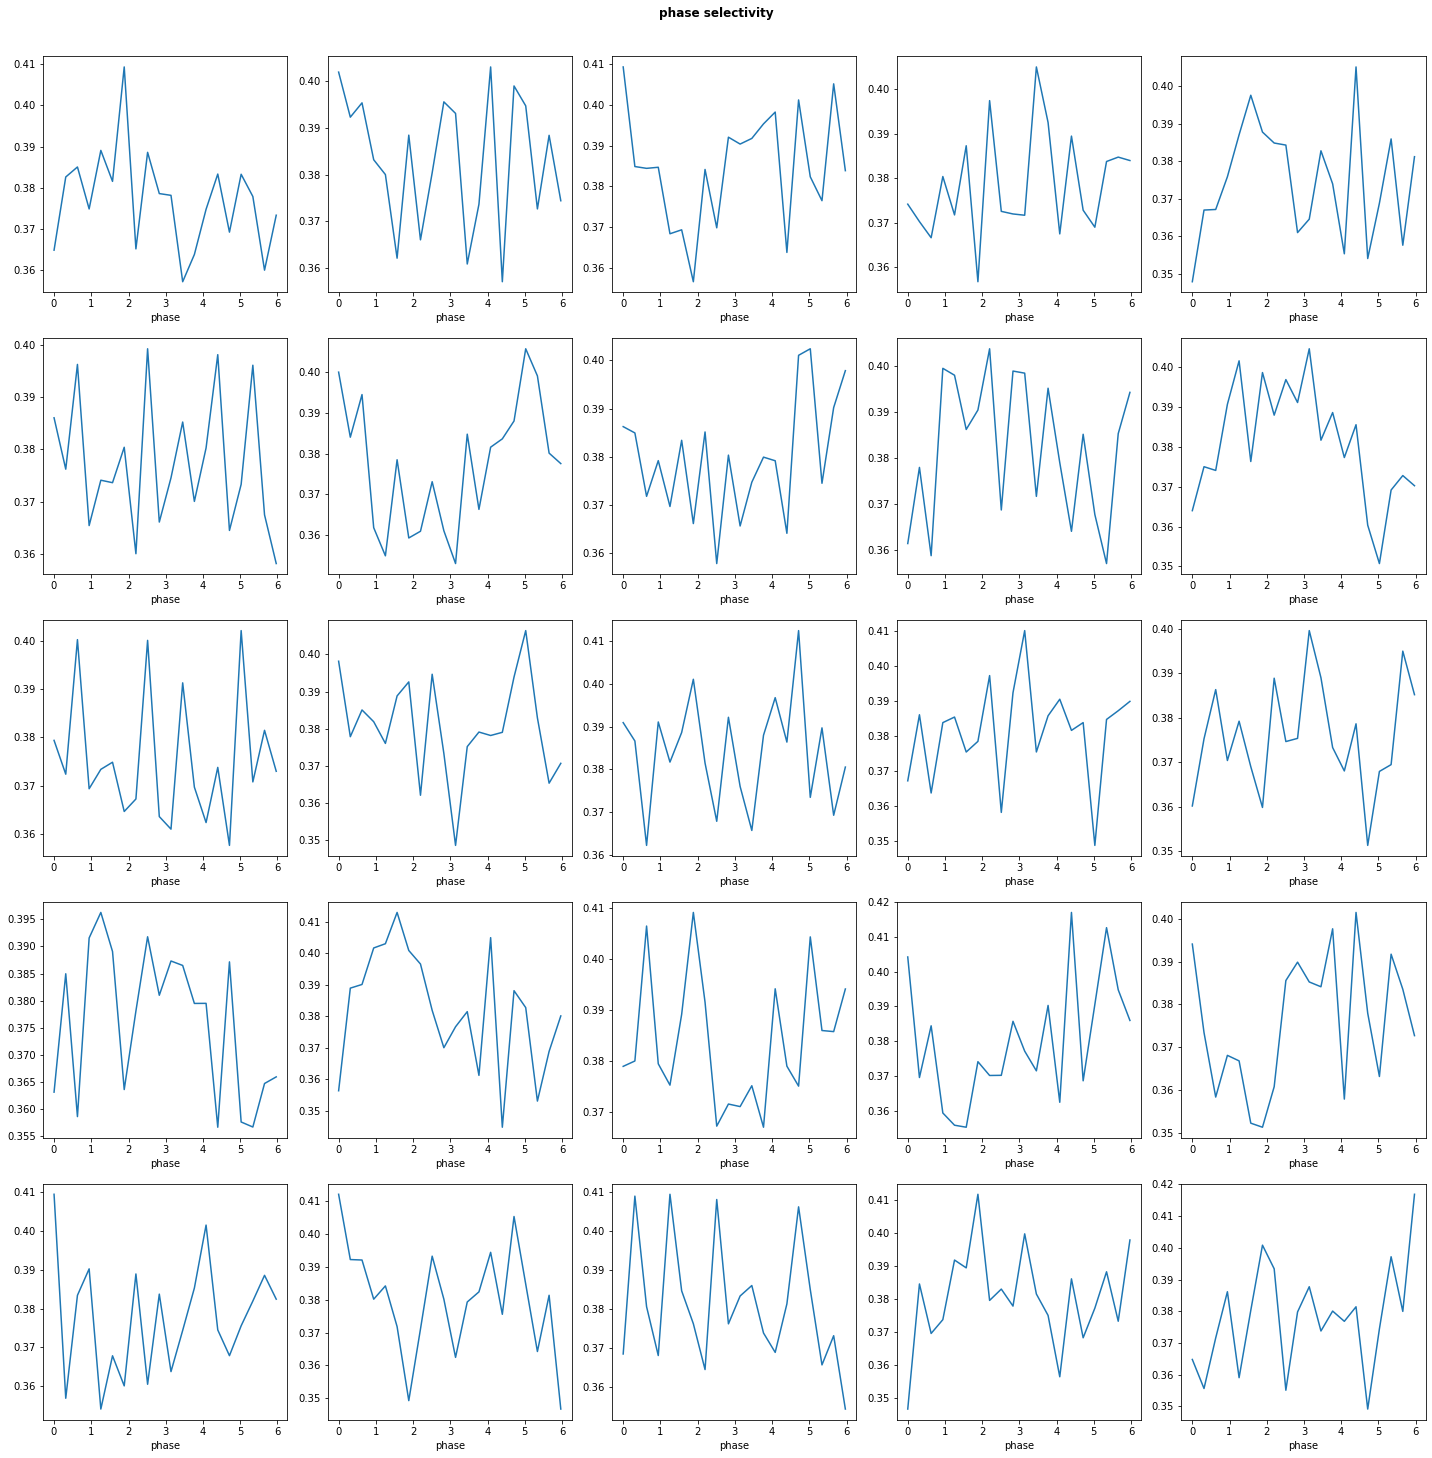

In [12]:
model_random_fp.plot_all()

In [ ]:
# ## Apply noise reduction
# # data = PCA_reduction(data, 5)
# # data = z_cutoff(data,2)

# ## Analyze shape
# persistence(data,homdim=2,coeff=2)
# persistence(data,homdim=2,coeff=3)

# ## Decode first parameter
# decoding1 = cohomological_parameterization(data, coeff=23)
# show_feature(decoding1)
# plot_mean_against_index(data,decoding1,"orientation")
# plot_mean_against_index(data,decoding1,"phase")
# # plot_data(data,transformation="PCA", labels=decoding1,
# #           colors=["Twilight","Viridis","Twilight","Viridis","Twilight"])

# ## Decode second parameter
# # reduced_data = remove_feature(data, decoding1, cut_amplitude=0.5)
# # decoding2 = cohomological_parameterization(reduced_data, coeff=23)
# # show_feature(decoding2)
# # plot_mean_against_index(data,decoding2,"orientation")
# # plot_mean_against_index(data,decoding2,"phase")
# # plot_data(data,transformation="PCA", labels=decoding2,
# #           colors=["Twilight","Viridis","Twilight","Viridis","Twilight"])


In [16]:
sp.init_printing()
k, x0, y0, phi, theta, sigma_x, sigma_y, sigma, x, y = sp.symbols(r'k x_0 y_0 \phi \theta \sigma_x \sigma_y \sigma x y')

In [17]:
sigma_x = sigma_y = sigma

In [14]:
grating_f = sp.cos(k * (x - x0) * sp.cos(theta) + k * (y - y0) * sp.sin(theta) + phi)

In [18]:
# p = sp.cos(phi) * sp.cos(k*x0*sp.cos(theta) + k*y0*sp.sin(theta)) * sp.exp(k**2 * (sigma_x **2 * (1 + sp.cos(theta))**2 + sigma_y**2 * sp.sin(theta) **2) / 2)
# p = sp.cosh(k**2 * sigma_x**2 * sp.cos(theta)) * sp.exp(k ** 2 * (1 + sp.cos(theta) ** 2) / 2) * sp.cos(phi - k * (x0 * sp.cos(theta) + y0 * sp.sin(theta)))

p = sp.cosh(k ** 2 * sigma ** 2 * sp.cos(theta) * 4) * sp.exp(-4 * k ** 2 * sigma ** 2) * sp.cos(
    phi - k * (x0 * sp.cos(theta) + y0 * sp.sin(theta)))
p

In [19]:
def calc(theta_, phi_, x_=0, y_=0, k_=1, sigma_x_=1, sigma_y_=1):
    theta_ *= np.pi / 180
    phi_ *= np.pi / 180
    return float(p.evalf(subs={x0: x_, y0: y_, k: k_, sigma_x: sigma_x_, sigma_y: sigma_y_, theta: theta_, phi: phi_}))

In [20]:
%matplotlib inline
@widgets.interact(
 k = widgets.FloatSlider(1, min=0, max=2, step=0.1),
 sigma_x = widgets.FloatSlider(1, min=0, max=2, step=0.1),
 sigma_y = widgets.FloatSlider(1, min=0, max=2, step=0.1),
x = widgets.FloatSlider(0, min=0, max=2, step=0.1),
    y = widgets.FloatSlider(0, min=0, max=2, step=0.1),
)
def plot_analytic(k=1, sigma_x=1, sigma_y=1, x=0, y=0):
    plt.imshow(np.array([[calc(theta, phi, x, y, k, sigma_x, sigma_y) for phi in range(0, 370, 10)] for theta in range(0, 190, 10)]), extent=[0, 360, 180, 0], cmap='viridis')
    plt.xlabel('phase')
    plt.ylabel('orientation')

interactive(children=(FloatSlider(value=1.0, description='k', max=2.0), FloatSlider(value=1.0, description='si…

In [4]:
%matplotlib inline
@widgets.interact(
 stim_theta = widgets.FloatSlider(0, min=0, max=180, step=5),
 stim_phi = widgets.FloatSlider(90, min=0, max=360, step=10),
 stim_freq = widgets.FloatSlider(1.5, min=0, max=10, step=0.5),
#  RF_theta = widgets.FloatSlider(0, min=0, max=180, step=5),
 RF_phi = widgets.FloatSlider(90, min=0, max=360, step=10),
 RF_freq = widgets.FloatSlider(1.5, min=0, max=10, step=0.5),
 RF_radius = widgets.FloatSlider(0.5, min=0, max=1, step=0.1), 
 RF_x = widgets.FloatSlider(0.5, min=-1, max=1, step=0.1),
 RF_y = widgets.FloatSlider(-0.5, min=-1, max=1, step=0.1)
 )

def plot_grating(stim_theta, stim_phi, stim_freq, RF_phi, RF_freq, RF_radius, RF_x, RF_y):
    RF_theta = 0
    stim_grating = (stim_theta/180*np.pi, stim_freq, stim_phi/180*np.pi, 1)
    RF_grating = (RF_theta/180*np.pi, RF_freq, RF_phi/180*np.pi, 1)
    stim_grat_image = gratings.grating_image(grating=stim_grating, plot=False)
    RF_grat_image = gratings.grating_image(grating=RF_grating, gabor=True, rf_sigma=RF_radius, center=(RF_y, RF_x), plot=False)
    
    fig, ax = plt.subplots(1,5, figsize=(25,6))

    ax[0].imshow(stim_grat_image,"gray", vmin = -1, vmax = 1, extent=[-1,1,1,-1]) 
    receptive_field = plt.Circle((RF_x, RF_y), RF_radius, color='b', fill=False)
    ax[0].add_patch(receptive_field)
    ax[0].legend([receptive_field], ['receptive field'])
    ax[0].invert_yaxis()

    ax[1].imshow(RF_grat_image,"gray", vmin = -1, vmax = 1, extent=[-1,1,1,-1]) 
    receptive_field = plt.Circle((RF_x, RF_y), RF_radius, color='b', fill=False)
    ax[1].add_patch(receptive_field)
    ax[1].legend([receptive_field], ['receptive field'])    
    ax[1].invert_yaxis()

    response = gratings.response(RF_grating, stim_grating, rf_sigma=RF_radius, center=(RF_y, RF_x))
    ax[2].axhline(response)
    ax[2].set(ylim=[0,1])

    # Nstim = (20, 1, 20, 1)
    # stim_list = gratings.get_locations(Nstim)
    # rates = np.zeros([len(stim_list)])
    # iterator = trange(0, len(stim_list), position=0, leave=True)
    # iterator.set_description("Simulating data stim_list")
    # for i in iterator:
    #     rates[i] = response(stim_list[i], RF_grating, rf_sigma=RF_radius, center=(RF_y, RF_x))

    plt.show()

interactive(children=(FloatSlider(value=0.0, description='stim_theta', max=180.0, step=5.0), FloatSlider(value…